In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import Counter
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

from pathlib import Path
import os

# custom modules
from models import Generator, Discriminator
from custom_dataset import CustomSequenceDataset
from preprocess_data import read_adfa_data, sequence_to_graph, fetch_graph_data
from utils import get_device, plot_loss_curve, evaluate_gcn_model
from classifiers import GCNModel
from train import train_gan_model
from train import train_gcn_model
from models import init_weights

In [2]:
# for reproducibility
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# read, preprocess, and fetch the ADFA datasets


In [3]:
data_folder = "ADFA"  # make sure "ADFA" folder in the parent directory of this project's folder [ie., your codes]
current_directory = Path(os.getcwd())
parent_path = current_directory.parent.absolute()
# print(current_directory.parent.absolute())

full_data_folder_path = os.path.join(parent_path, data_folder)

In [4]:
adfa_sub_folders = [
    "Training_Data_Master",
    "Validation_Data_Master",
    "Attack_Data_Master",
]

benign_training_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[0])
benign_validation_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[1])

attack_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[2])


# read the sub folders
benign_train_sequences, benign_train_labels = read_adfa_data(benign_training_data_path)

benign_val_sequences, benign_val_labels = read_adfa_data(benign_validation_data_path)

attack_sequences, attack_labels = read_adfa_data(attack_data_path)


data = benign_train_sequences + benign_val_sequences + attack_sequences
labels = benign_train_labels + benign_val_labels + attack_labels

# perform  70 % training and 30% testing set split

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

len(train_data), len(train_labels), len(test_data), len(test_labels)

Read 833 sequences from Training_Data_Master
Read 4372 sequences from Validation_Data_Master
Read 746 sequences from Attack_Data_Master


(4165, 4165, 1786, 1786)

In [5]:
len(attack_sequences)

746

In [6]:
# Data is imbalanced: 1666 samples of benign & 1051 samples of attack (malignant) will be used for training the GCN model
Counter(train_labels)

Counter({0: 3643, 1: 522})

In [7]:
Counter(test_labels)

Counter({0: 1562, 1: 224})

In [8]:
# Create a custom dataset
batch_size = 256
# convert train_data sequences and val_data sequences into graphs

train_graph_dataset = fetch_graph_data(train_data, train_labels)
val_graph_dataset = fetch_graph_data(test_data, test_labels)


# Create a data loader
graph_train_loader = DataLoader(
    train_graph_dataset, batch_size=batch_size, shuffle=True
)
graph_val_loader = DataLoader(val_graph_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# you can see the graph data: it has edge_index, weight, num_nodes, y (label of the graph, i.e., malign or benign), and x (node features). Here, x is a list of integers representing the node features. They need to be converted to a one-hot vector of size vocab_size or vector of embedded representation.
train_graph_dataset[0]

Data(edge_index=[2, 63], weight=[63], num_nodes=17, x=[1], y=0)

In [10]:
# device = get_device()
vocab_size = 342
hidden_dim = 128  # also the number of hidden nodes in the GCN. Can be set to 128, 256 or 512. If you have more GPU, you can increase it. However, you may face overfitting. Increase dropout if you face overfitting. Like dropout = 0.6, 0.7, 0.8
num_classes = 2
dropout = 0.4
output_dim = num_classes
# number of GCN layers, depending on your GPU, set it to any integer from 2 to 5.
num_layers = 4
EPOCHS_GCN = 5  # change this  100 to get more accurate results


device = torch.device("cpu")


gcn_model = GCNModel(
    in_channels=vocab_size,
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

train_losses, train_f1_scores = train_gcn_model(
    gcn_model,
    graph_train_loader,
    vocab_size=vocab_size,
    epochs=EPOCHS_GCN,
    device=device,
)

100%|██████████| 17/17 [00:01<00:00, 12.00it/s]


Epoch 1 / 5, Loss: 0.5255, F1 Score: 0.0000


100%|██████████| 17/17 [00:01<00:00, 12.51it/s]


Epoch 2 / 5, Loss: 0.4380, F1 Score: 0.0000


100%|██████████| 17/17 [00:01<00:00, 14.13it/s]


Epoch 3 / 5, Loss: 0.4360, F1 Score: 0.0000


100%|██████████| 17/17 [00:01<00:00, 12.79it/s]


Epoch 4 / 5, Loss: 0.4172, F1 Score: 0.2267


100%|██████████| 17/17 [00:01<00:00, 13.33it/s]

Epoch 5 / 5, Loss: 0.4011, F1 Score: 0.5571


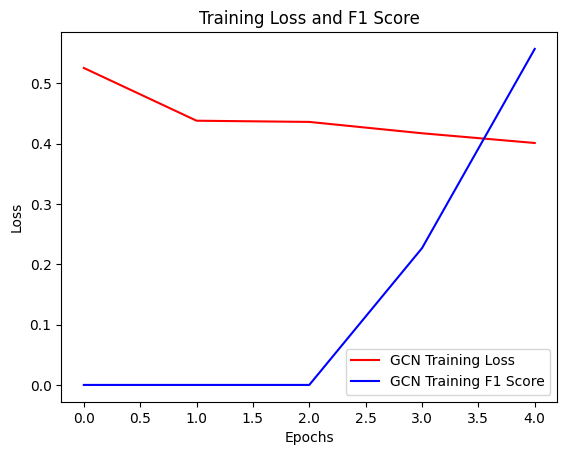

In [11]:
x = np.arange(EPOCHS_GCN, dtype=int)
plt.plot(x, train_losses, color="red", label="GCN Training Loss")
plt.plot(x, train_f1_scores, color="blue", label="GCN Training F1 Score")
plt.title("Training Loss and F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
evaluate_gcn_model(gcn_model, graph_val_loader, vocab_size=vocab_size, device=device)

GCN performance:
Accuracy: 0.9233
Precision: 0.8965
Recall: 0.7248
F1 score: 0.7791
MCC: 0.5971


In [13]:
# PREPARE DATASET FOR GAN MODEL: pad the sequences to make them of same length, then trim them to a fixed sequence length to avoid too much padding.
# convert train_data sequences and val_data sequences into graphs
SEQUENCE_LENGTH = 100
train_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in train_data],
    batch_first=True,
)

val_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in test_data],
    batch_first=True,
)

train_data_padded.shape, val_data_padded.shape

(torch.Size([4165, 4094]), torch.Size([1786, 4494]))

In [14]:
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler


train_data_padded[:, SEQUENCE_LENGTH].shape, val_data_padded[:SEQUENCE_LENGTH].shape

# our dataset will be of shape (n_samples, SEQUENCE_LENGTH).
train_dataset = CustomSequenceDataset(
    train_data_padded[:, :SEQUENCE_LENGTH], train_labels
)
val_dataset = CustomSequenceDataset(val_data_padded[:, :SEQUENCE_LENGTH], test_labels)


# Assuming 'train_dataset' is your dataset for training
# and 'y_train' is a list of class labels for the dataset

# Calculate the class weights
class_sample_count = np.array(
    [len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)]
)
weight = 1.0 / class_sample_count

# Assign weights to each sample
samples_weight = np.array([weight[t] for t in train_labels])
samples_weight = torch.from_numpy(samples_weight)

# Create the sampler
# class_weights = samples_weight.type('torch.DoubleTensor')
class_weights = torch.tensor([1.0, 1.0])

sampler = WeightedRandomSampler(class_weights, len(samples_weight))

# Use the sampler in the DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    shuffle=False,
    # drop_last=True
)

# if you do not want to use Balanced Weight ( or balanced class training), common the line of code above, and uncomment the line below
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# check the data is balanced

for data, labels in train_loader:
    print(Counter(labels.tolist()))

Counter({0: 140, 1: 116})
Counter({0: 131, 1: 125})
Counter({0: 130, 1: 126})
Counter({0: 133, 1: 123})
Counter({0: 130, 1: 126})
Counter({1: 131, 0: 125})
Counter({0: 136, 1: 120})
Counter({1: 130, 0: 126})
Counter({1: 134, 0: 122})
Counter({1: 133, 0: 123})
Counter({0: 131, 1: 125})
Counter({1: 130, 0: 126})
Counter({1: 132, 0: 124})
Counter({0: 131, 1: 125})
Counter({1: 132, 0: 124})
Counter({0: 135, 1: 121})
Counter({1: 47, 0: 22})


In [24]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 342  # we have 342 unique system calls in the ADFA dataset
seq_len = SEQUENCE_LENGTH  # sequence length of the ADFA dataset with less than 120, will be padded. If sequence is longer than 120, it will be truncated.
output_dim = vocab_size
embed_dim = 10
dropout = 0.5
batch_size = 256  # 32
n_samples = 1000
num_classes = 2
lr = 4e-4  # 5e-5  # 2e-6
epochs = 150
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
device = get_device()
temperature = 0.2  # 0.1

gen = Generator(
    latent_dim,
    seq_len,
    hidden_dim,
    output_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(
    vocab_size,
    seq_len,
    hidden_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)


# To apply weights initialization to your GAN model, uncomment the two lines of code below:

gen.apply(init_weights)
disc.apply(init_weights)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [25]:
device = get_device()

In [26]:
# input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
# input_labels = torch.randint(0, num_classes, (n_samples,))
# train_dataset = CustomSequenceDataset(input_data, input_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
# note that the temperature is set to any value between 0 and 1.
g_losses, d_losses = train_gan_model(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    tau=temperature,
    warm_up_epochs=0,
)

Epoch 1 / 150


100%|██████████| 17/17 [00:02<00:00,  7.22it/s]


D Loss: 1.3860, G Loss: -0.6973
Epoch 2 / 150


100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


D Loss: 1.3866, G Loss: -0.6928
Epoch 3 / 150


100%|██████████| 17/17 [00:01<00:00,  8.96it/s]


D Loss: 1.3868, G Loss: -0.6928
Epoch 4 / 150


100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


D Loss: 1.3860, G Loss: -0.6930
Epoch 5 / 150


100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


D Loss: 1.3862, G Loss: -0.6936
Epoch 6 / 150


100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


D Loss: 1.3865, G Loss: -0.6931
Epoch 7 / 150


100%|██████████| 17/17 [00:01<00:00,  9.12it/s]


D Loss: 1.3860, G Loss: -0.6936
Epoch 8 / 150


100%|██████████| 17/17 [00:01<00:00,  8.81it/s]


D Loss: 1.3866, G Loss: -0.6934
Epoch 9 / 150


100%|██████████| 17/17 [00:01<00:00,  9.27it/s]


D Loss: 1.3866, G Loss: -0.6926
Epoch 10 / 150


100%|██████████| 17/17 [00:01<00:00,  8.59it/s]


D Loss: 1.3865, G Loss: -0.6926
Epoch 11 / 150


100%|██████████| 17/17 [00:01<00:00,  8.75it/s]


D Loss: 1.3866, G Loss: -0.6912
Epoch 12 / 150


100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


D Loss: 1.3861, G Loss: -0.6929
Epoch 13 / 150


100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


D Loss: 1.3869, G Loss: -0.6935
Epoch 14 / 150


100%|██████████| 17/17 [00:01<00:00,  8.95it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 15 / 150


100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


D Loss: 1.3861, G Loss: -0.6925
Epoch 16 / 150


100%|██████████| 17/17 [00:02<00:00,  8.41it/s]


D Loss: 1.3869, G Loss: -0.6928
Epoch 17 / 150


100%|██████████| 17/17 [00:02<00:00,  8.47it/s]


D Loss: 1.3862, G Loss: -0.6931
Epoch 18 / 150


100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


D Loss: 1.3869, G Loss: -0.6931
Epoch 19 / 150


100%|██████████| 17/17 [00:02<00:00,  8.35it/s]


D Loss: 1.3865, G Loss: -0.6932
Epoch 20 / 150


100%|██████████| 17/17 [00:02<00:00,  8.44it/s]


D Loss: 1.3872, G Loss: -0.6941
Epoch 21 / 150


100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


D Loss: 1.3868, G Loss: -0.6941
Epoch 22 / 150


100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


D Loss: 1.3859, G Loss: -0.6940
Epoch 23 / 150


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


D Loss: 1.3861, G Loss: -0.6932
Epoch 24 / 150


100%|██████████| 17/17 [00:02<00:00,  8.24it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 25 / 150


100%|██████████| 17/17 [00:02<00:00,  8.46it/s]


D Loss: 1.3863, G Loss: -0.6921
Epoch 26 / 150


100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


D Loss: 1.3866, G Loss: -0.6926
Epoch 27 / 150


100%|██████████| 17/17 [00:01<00:00,  8.62it/s]


D Loss: 1.3870, G Loss: -0.6936
Epoch 28 / 150


100%|██████████| 17/17 [00:01<00:00,  8.60it/s]


D Loss: 1.3867, G Loss: -0.6937
Epoch 29 / 150


100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


D Loss: 1.3865, G Loss: -0.6938
Epoch 30 / 150


100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


D Loss: 1.3865, G Loss: -0.6931
Epoch 31 / 150


100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


D Loss: 1.3860, G Loss: -0.6930
Epoch 32 / 150


100%|██████████| 17/17 [00:02<00:00,  8.46it/s]


D Loss: 1.3860, G Loss: -0.6934
Epoch 33 / 150


100%|██████████| 17/17 [00:01<00:00,  8.73it/s]


D Loss: 1.3868, G Loss: -0.6931
Epoch 34 / 150


100%|██████████| 17/17 [00:02<00:00,  8.42it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 35 / 150


100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


D Loss: 1.3864, G Loss: -0.6939
Epoch 36 / 150


100%|██████████| 17/17 [00:01<00:00,  8.62it/s]


D Loss: 1.3866, G Loss: -0.6932
Epoch 37 / 150


100%|██████████| 17/17 [00:01<00:00,  8.59it/s]


D Loss: 1.3863, G Loss: -0.6924
Epoch 38 / 150


100%|██████████| 17/17 [00:01<00:00,  8.65it/s]


D Loss: 1.3866, G Loss: -0.6938
Epoch 39 / 150


100%|██████████| 17/17 [00:01<00:00,  8.70it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 40 / 150


100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


D Loss: 1.3862, G Loss: -0.6928
Epoch 41 / 150


100%|██████████| 17/17 [00:01<00:00,  8.61it/s]


D Loss: 1.3868, G Loss: -0.6929
Epoch 42 / 150


100%|██████████| 17/17 [00:01<00:00,  8.64it/s]


D Loss: 1.3868, G Loss: -0.6938
Epoch 43 / 150


100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


D Loss: 1.3863, G Loss: -0.6942
Epoch 44 / 150


100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


D Loss: 1.3868, G Loss: -0.6934
Epoch 45 / 150


100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


D Loss: 1.3861, G Loss: -0.6936
Epoch 46 / 150


100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


D Loss: 1.3864, G Loss: -0.6933
Epoch 47 / 150


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


D Loss: 1.3860, G Loss: -0.6931
Epoch 48 / 150


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


D Loss: 1.3866, G Loss: -0.6935
Epoch 49 / 150


100%|██████████| 17/17 [00:02<00:00,  8.47it/s]


D Loss: 1.3868, G Loss: -0.6930
Epoch 50 / 150


100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


D Loss: 1.3862, G Loss: -0.6929
Epoch 51 / 150


100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


D Loss: 1.3864, G Loss: -0.6930
Epoch 52 / 150


100%|██████████| 17/17 [00:02<00:00,  8.40it/s]


D Loss: 1.3862, G Loss: -0.6929
Epoch 53 / 150


100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


D Loss: 1.3863, G Loss: -0.6929
Epoch 54 / 150


100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


D Loss: 1.3860, G Loss: -0.6926
Epoch 55 / 150


100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


D Loss: 1.3863, G Loss: -0.6934
Epoch 56 / 150


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


D Loss: 1.3864, G Loss: -0.6933
Epoch 57 / 150


100%|██████████| 17/17 [00:02<00:00,  8.26it/s]


D Loss: 1.3862, G Loss: -0.6929
Epoch 58 / 150


100%|██████████| 17/17 [00:02<00:00,  5.94it/s]


D Loss: 1.3868, G Loss: -0.6924
Epoch 59 / 150


100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


D Loss: 1.3862, G Loss: -0.6929
Epoch 60 / 150


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


D Loss: 1.3861, G Loss: -0.6938
Epoch 61 / 150


100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


D Loss: 1.3864, G Loss: -0.6933
Epoch 62 / 150


100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 63 / 150


100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


D Loss: 1.3866, G Loss: -0.6928
Epoch 64 / 150


100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


D Loss: 1.3867, G Loss: -0.6930
Epoch 65 / 150


100%|██████████| 17/17 [00:02<00:00,  7.20it/s]


D Loss: 1.3865, G Loss: -0.6935
Epoch 66 / 150


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


D Loss: 1.3866, G Loss: -0.6932
Epoch 67 / 150


100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


D Loss: 1.3866, G Loss: -0.6937
Epoch 68 / 150


100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


D Loss: 1.3861, G Loss: -0.6934
Epoch 69 / 150


100%|██████████| 17/17 [00:02<00:00,  7.62it/s]


D Loss: 1.3866, G Loss: -0.6932
Epoch 70 / 150


100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


D Loss: 1.3867, G Loss: -0.6933
Epoch 71 / 150


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


D Loss: 1.3862, G Loss: -0.6927
Epoch 72 / 150


100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 73 / 150


100%|██████████| 17/17 [00:02<00:00,  7.37it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 74 / 150


100%|██████████| 17/17 [00:02<00:00,  6.20it/s]


D Loss: 1.3858, G Loss: -0.6932
Epoch 75 / 150


100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


D Loss: 1.3867, G Loss: -0.6937
Epoch 76 / 150


100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


D Loss: 1.3859, G Loss: -0.6935
Epoch 77 / 150


100%|██████████| 17/17 [00:02<00:00,  7.48it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 78 / 150


100%|██████████| 17/17 [00:02<00:00,  7.42it/s]


D Loss: 1.3868, G Loss: -0.6936
Epoch 79 / 150


100%|██████████| 17/17 [00:02<00:00,  7.90it/s]


D Loss: 1.3865, G Loss: -0.6934
Epoch 80 / 150


100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


D Loss: 1.3863, G Loss: -0.6934
Epoch 81 / 150


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


D Loss: 1.3864, G Loss: -0.6926
Epoch 82 / 150


100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


D Loss: 1.3865, G Loss: -0.6937
Epoch 83 / 150


100%|██████████| 17/17 [00:02<00:00,  6.47it/s]


D Loss: 1.3865, G Loss: -0.6929
Epoch 84 / 150


100%|██████████| 17/17 [00:02<00:00,  7.44it/s]


D Loss: 1.3863, G Loss: -0.6934
Epoch 85 / 150


100%|██████████| 17/17 [00:02<00:00,  7.51it/s]


D Loss: 1.3862, G Loss: -0.6932
Epoch 86 / 150


100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


D Loss: 1.3865, G Loss: -0.6935
Epoch 87 / 150


100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


D Loss: 1.3865, G Loss: -0.6930
Epoch 88 / 150


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


D Loss: 1.3865, G Loss: -0.6937
Epoch 89 / 150


100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


D Loss: 1.3861, G Loss: -0.6932
Epoch 90 / 150


100%|██████████| 17/17 [00:02<00:00,  7.49it/s]


D Loss: 1.3862, G Loss: -0.6931
Epoch 91 / 150


100%|██████████| 17/17 [00:02<00:00,  8.24it/s]


D Loss: 1.3865, G Loss: -0.6938
Epoch 92 / 150


100%|██████████| 17/17 [00:02<00:00,  7.56it/s]


D Loss: 1.3866, G Loss: -0.6933
Epoch 93 / 150


100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 94 / 150


100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


D Loss: 1.3864, G Loss: -0.6933
Epoch 95 / 150


100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


D Loss: 1.3866, G Loss: -0.6935
Epoch 96 / 150


100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


D Loss: 1.3861, G Loss: -0.6929
Epoch 97 / 150


100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 98 / 150


100%|██████████| 17/17 [00:02<00:00,  7.86it/s]


D Loss: 1.3863, G Loss: -0.6928
Epoch 99 / 150


100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


D Loss: 1.3865, G Loss: -0.6932
Epoch 100 / 150


100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


D Loss: 1.3866, G Loss: -0.6932
Epoch 101 / 150


100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


D Loss: 1.3865, G Loss: -0.6930
Epoch 102 / 150


100%|██████████| 17/17 [00:02<00:00,  7.26it/s]


D Loss: 1.3863, G Loss: -0.6934
Epoch 103 / 150


100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 104 / 150


100%|██████████| 17/17 [00:02<00:00,  8.24it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 105 / 150


100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


D Loss: 1.3862, G Loss: -0.6932
Epoch 106 / 150


100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


D Loss: 1.3865, G Loss: -0.6932
Epoch 107 / 150


100%|██████████| 17/17 [00:02<00:00,  8.20it/s]


D Loss: 1.3861, G Loss: -0.6931
Epoch 108 / 150


100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


D Loss: 1.3863, G Loss: -0.6933
Epoch 109 / 150


100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 110 / 150


100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


D Loss: 1.3863, G Loss: -0.6935
Epoch 111 / 150


100%|██████████| 17/17 [00:02<00:00,  7.07it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 112 / 150


100%|██████████| 17/17 [00:02<00:00,  7.50it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 113 / 150


100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 114 / 150


100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 115 / 150


100%|██████████| 17/17 [00:02<00:00,  7.87it/s]


D Loss: 1.3863, G Loss: -0.6929
Epoch 116 / 150


100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


D Loss: 1.3863, G Loss: -0.6932
Epoch 117 / 150


100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 118 / 150


100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


D Loss: 1.3866, G Loss: -0.6931
Epoch 119 / 150


100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 120 / 150


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


D Loss: 1.3862, G Loss: -0.6930
Epoch 121 / 150


100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


D Loss: 1.3863, G Loss: -0.6932
Epoch 122 / 150


100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


D Loss: 1.3865, G Loss: -0.6934
Epoch 123 / 150


100%|██████████| 17/17 [00:02<00:00,  8.32it/s]


D Loss: 1.3862, G Loss: -0.6930
Epoch 124 / 150


100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


D Loss: 1.3863, G Loss: -0.6934
Epoch 125 / 150


100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 126 / 150


100%|██████████| 17/17 [00:02<00:00,  8.06it/s]


D Loss: 1.3864, G Loss: -0.6934
Epoch 127 / 150


100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


D Loss: 1.3862, G Loss: -0.6934
Epoch 128 / 150


100%|██████████| 17/17 [00:02<00:00,  8.30it/s]


D Loss: 1.3864, G Loss: -0.6932
Epoch 129 / 150


100%|██████████| 17/17 [00:02<00:00,  8.33it/s]


D Loss: 1.3864, G Loss: -0.6930
Epoch 130 / 150


100%|██████████| 17/17 [00:02<00:00,  8.20it/s]


D Loss: 1.3864, G Loss: -0.6933
Epoch 131 / 150


100%|██████████| 17/17 [00:02<00:00,  8.28it/s]


D Loss: 1.3863, G Loss: -0.6930
Epoch 132 / 150


100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 133 / 150


100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


D Loss: 1.3865, G Loss: -0.6927
Epoch 134 / 150


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


D Loss: 1.3862, G Loss: -0.6931
Epoch 135 / 150


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 136 / 150


100%|██████████| 17/17 [00:02<00:00,  8.28it/s]


D Loss: 1.3862, G Loss: -0.6931
Epoch 137 / 150


100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


D Loss: 1.3864, G Loss: -0.6931
Epoch 138 / 150


100%|██████████| 17/17 [00:02<00:00,  7.09it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 139 / 150


100%|██████████| 17/17 [00:02<00:00,  6.91it/s]


D Loss: 1.3865, G Loss: -0.6933
Epoch 140 / 150


100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


D Loss: 1.3865, G Loss: -0.6930
Epoch 141 / 150


100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


D Loss: 1.3865, G Loss: -0.6934
Epoch 142 / 150


100%|██████████| 17/17 [00:02<00:00,  8.23it/s]


D Loss: 1.3863, G Loss: -0.6928
Epoch 143 / 150


100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


D Loss: 1.3862, G Loss: -0.6928
Epoch 144 / 150


100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


D Loss: 1.3863, G Loss: -0.6931
Epoch 145 / 150


100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


D Loss: 1.3865, G Loss: -0.6933
Epoch 146 / 150


100%|██████████| 17/17 [00:02<00:00,  7.58it/s]


D Loss: 1.3862, G Loss: -0.6932
Epoch 147 / 150


100%|██████████| 17/17 [00:02<00:00,  7.47it/s]


D Loss: 1.3864, G Loss: -0.6929
Epoch 148 / 150


100%|██████████| 17/17 [00:02<00:00,  8.32it/s]


D Loss: 1.3861, G Loss: -0.6929
Epoch 149 / 150


100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


D Loss: 1.3866, G Loss: -0.6934
Epoch 150 / 150


100%|██████████| 17/17 [00:02<00:00,  8.23it/s]

D Loss: 1.3863, G Loss: -0.6932


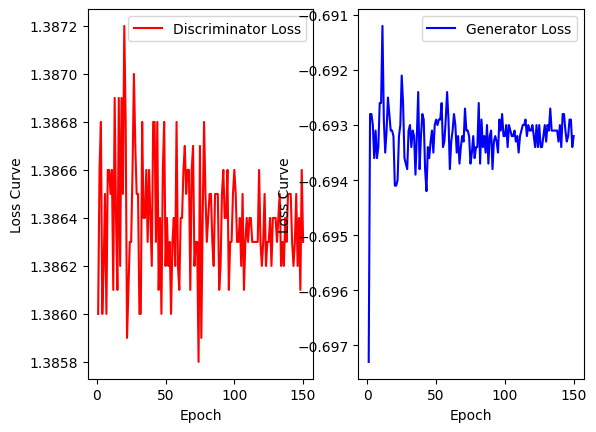

In [33]:
plot_loss_curve(d_losses, g_losses, epochs, normalize=False)

## generate fake samples


In [29]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, latent_dim))

# print("random noise shape", z.shape)
# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device)).detach().cpu()

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
# print(fake_data[0])

In [30]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
from pprint import pprint

fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see two generated sequences
pprint(fake_samples[:2])

array([[153,  67, 190, 113, 289, 267, 334, 184, 236, 228,  83, 231, 316,
        137,  34, 165,  22, 195, 256, 104, 225, 264, 256,  72,  71, 169,
        120, 160, 105, 334, 266, 339, 174, 199, 254, 334, 120, 234, 312,
         23, 104, 283, 307,  41, 251,   1, 143,  28, 131, 330,  64, 231,
        271, 282,  97, 315, 281, 109, 123, 288, 155,  81,  37, 213, 254,
         94, 162, 138,  17, 182, 316, 132,  10, 115, 181,  69, 275, 193,
        283, 209, 329, 293, 125, 195,  18, 162,  83, 313, 147, 231, 325,
        101, 131, 259, 299, 199,  43, 123, 177,   3],
       [  5,  30, 114,  89, 249, 335, 333,  49, 267, 185, 223,  84,   7,
         42,  74, 249,  59,  41, 245, 147, 223, 289, 164,  33, 110, 329,
        103, 100,  92, 148, 285,  76, 216,  52, 119,  28,  78, 139, 287,
        156, 297,  79, 260, 197, 165, 251,  71, 299, 186, 116, 118,  82,
        196, 287, 330,  85, 107, 246,  31, 318,  79,  24, 153,  64,  13,
         21,  70, 247,  38, 283,  34, 172,  98,  82, 329, 209,  76, 20

# Now, we can generate from generated tokens (i.e., sequence)

` To do so, we can use the sequence_to_graph() function given in the preprocess_data.py`


In [31]:
# convert the generated samples into a networkx graph and also pytorch_geometric graph data object
networkx_graph, pytorch_geometric_data = sequence_to_graph(fake_samples[0])

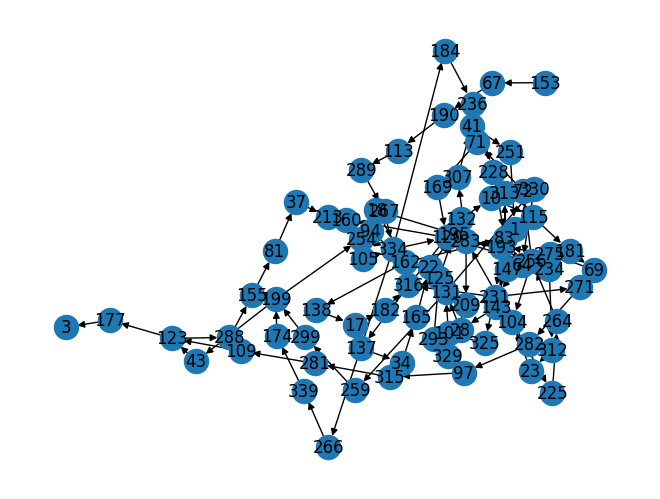

In [32]:
# you can see the networkx graph we generated
nx.draw(networkx_graph, with_labels=True)
plt.show()

# The Remaining Steps:

```
1 - generate many fake samples (sequences and their corresponding labels),

2 - add these fake sequences to train_data sequences, and add their fake_labels (benign or malign) to the trian_labels

3 - train a new GCNModel and compare performance before and after adding fake samples.


```
